In [20]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold # import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_selection import SelectFromModel

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import yellowbrick as yb

### Predict Energy consumption

In [2]:
dataset = pd.read_csv('data1/dataset.csv')

In [3]:
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Cooling:Electricity [kW](Hourly)',
       'Date/Time', 'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Monthly)', 'Fans:Electricity [kW](Hourly)',
       'Gas:Facility [kW](Hourly)', 'Gas:Facility [kW](Monthly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'Day', 'is_weekend',
       'is_holiday', 'Holiday_name', 'Friday', 'M

In [4]:
dataset_numeric = dataset[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'location_id', 'building_id', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER']]

In [5]:
dataset_numeric.describe()

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),...,USA_IL_CHICAGO-OHARE,USA_MN_MINNEAPOLIS,USA_TX_HOUSTON,USA_WA_SEATTLE,USA_NV_LAS_VEGAS,USA_CA_SAN_FRANCISCO,USA_AZ_PHOENIX,USA_GA_ATLANTA,USA_MD_BALTIMORE,USA_CO_BOULDER
count,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,...,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06
mean,5.588932e+01,2.026355e+02,1.707438e+01,9.162392e+01,9.860414e-01,6.356293e+01,5.320615e+01,1.016023e+01,4.099851e+01,1.790076e+01,...,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02
std,1.333567e+02,3.242529e+02,2.739628e+01,1.959991e+02,6.944747e+00,1.750998e+02,8.320485e+01,1.841612e+01,7.496627e+01,5.677064e+01,...,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01
min,0.000000e+00,1.925019e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+00,0.000000e+00,2.750027e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.558064e+01,5.147965e-01,2.188671e+00,0.000000e+00,0.000000e+00,8.089532e+00,0.000000e+00,3.788942e+00,2.000000e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.525502e-01,6.191023e+01,4.375339e+00,1.612785e+01,0.000000e+00,1.063959e-06,2.064387e+01,2.653365e+00,1.586394e+01,1.165121e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.510995e+01,2.191530e+02,2.552694e+01,8.384342e+01,0.000000e+00,4.634194e+01,5.323874e+01,9.905768e+00,4.351334e+01,8.775903e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.550041e+02,1.849288e+03,2.803934e+02,4.779020e+03,3.049323e+02,4.765562e+03,4.485665e+02,9.179980e+01,4.485665e+02,7.838779e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
corr_matrix = dataset_numeric.corr()
corr_matrix["Electricity:Facility [kW](Hourly)"].sort_values(ascending=False)

Electricity:Facility [kW](Hourly)             1.000000
InteriorEquipment:Electricity [kW](Hourly)    0.890501
Cooling:Electricity [kW](Hourly)              0.876445
Fans:Electricity [kW](Hourly)                 0.835990
InteriorLights:Electricity [kW](Hourly)       0.825711
RefBldgHospitalNew                            0.681053
Gas:Facility [kW](Hourly)                     0.449607
InteriorEquipment:Gas [kW](Hourly)            0.416995
RefBldgLargeOfficeNew                         0.416291
Heating:Gas [kW](Hourly)                      0.409033
Water Heater:WaterSystems:Gas [kW](Hourly)    0.155387
RefBldgSecondarySchoolNew                     0.138272
temperatureHigh                               0.066540
RefBldgLargeHotelNew                          0.062014
dewPoint                                      0.052271
is_weekend                                    0.034288
USA_TX_HOUSTON                                0.031984
USA_AZ_PHOENIX                                0.029572
Monday    

In [7]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
dataset_numeric_scaling = dataset_numeric[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover']]
scaled_df = scaler.fit_transform(dataset_numeric_scaling)
scaled_df = pd.DataFrame(scaled_df, columns=['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover'])

one_hot_encoded_data = dataset_numeric[['Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER']]

In [8]:
processed_data = pd.concat((scaled_df, one_hot_encoded_data), axis=1)

In [9]:
processed_data.head(5)

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),...,USA_IL_CHICAGO-OHARE,USA_MN_MINNEAPOLIS,USA_TX_HOUSTON,USA_WA_SEATTLE,USA_NV_LAS_VEGAS,USA_CA_SAN_FRANCISCO,USA_AZ_PHOENIX,USA_GA_ATLANTA,USA_MD_BALTIMORE,USA_CO_BOULDER
0,-0.419097,-0.556464,-0.375592,0.543680,-0.141984,0.768829,-0.627302,-0.551703,-0.473777,-0.315317,...,0,0,0,0,0,0,0,0,0,0
1,-0.419097,-0.561173,-0.431316,0.332627,-0.141984,0.532586,-0.627302,-0.551703,-0.473777,-0.315317,...,0,0,0,0,0,0,0,0,0,0
2,-0.419097,-0.556922,-0.381013,0.449567,-0.141984,0.663483,-0.627302,-0.551703,-0.473777,-0.315317,...,0,0,0,0,0,0,0,0,0,0
3,-0.419097,-0.561861,-0.439462,0.269537,-0.141984,0.461965,-0.627302,-0.551703,-0.473777,-0.315317,...,0,0,0,0,0,0,0,0,0,0
4,-0.419097,-0.557347,-0.386037,0.414956,-0.141984,0.624741,-0.627302,-0.551703,-0.473777,-0.315317,...,0,0,0,0,0,0,0,0,0,0


In [80]:
"""
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                                    'Fans:Electricity [kW](Hourly)',
                                   'InteriorEquipment:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER',
        'time', 'sunriseTime', 'sunsetTime']]
"""
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER',
        'time', 'sunriseTime', 'sunsetTime']]

dataset_labels = processed_data[['Electricity:Facility [kW](Hourly)']]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.1)

In [82]:
model = LinearRegression()
est = model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
print('Coefficients: {}'.format(model.coef_))

Linear Regression model
Mean Squared Error: 0.083
Coefficient of Determination: 0.917
Coefficients: [[ 5.94504195e-01  2.14261193e+08  2.61934792e-02 -1.91414622e+08
  -2.01320329e+07 -6.20602191e+07 -4.63260757e-03 -1.55304998e-03
   4.87076142e-04  8.32661986e-04  1.18166208e-04 -1.51034924e-01
   3.48678685e-02 -1.75537615e-01  2.93322644e-02  1.58979465e-02
   1.96556902e-02 -1.53375178e-02  2.41392890e-02  1.57016411e-03
  -1.07366978e-02 -9.79427557e+09 -2.19371535e-02 -6.61563054e+09
  -6.61563054e+09  3.17864503e+09  3.17864503e+09 -6.61563054e+09
  -6.61563054e+09 -6.61563054e+09  3.17891071e+08  3.17891072e+08
   3.17891071e+08  3.17891073e+08  3.17891071e+08  3.17891071e+08
   3.17891071e+08  3.17891071e+08  3.17891071e+08  3.17891072e+08
   3.17891071e+08  3.17891071e+08  3.17891071e+08  3.17891071e+08
   3.17891072e+08  3.17891071e+08 -3.69299967e+08 -3.69299967e+08
  -3.69299967e+08 -3.69299967e+08 -3.69299967e+08 -3.69299967e+08
  -3.69299967e+08 -3.69299967e+08 -3.69299

In [92]:
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)

expected = y_test
predicted = ridge.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))

Ridge model
Mean Squared Error: 0.083
Coefficient of Determination: 0.917


In [91]:
regr_cv = RidgeCV(alphas=[0.5, 100, 1000])
regr_cv.fit(X_train, y_train)

expected = y_test
predicted = regr_cv.predict(X_test)

print('Ridge model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Ridge model
Mean squared error = 0.083
R2 score = 0.917


In [85]:
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
expected = y_test
predicted = regr_trans.predict(X_test)

print('Transformed target regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Transformed target regressor
Mean squared error = 0.096
R2 score = 0.904


In [86]:
lasso = Lasso(alpha=0.2, max_iter=10e5)
lasso.fit(X_train,y_train)
expected = y_test
predicted = lasso.predict(X_test)

print('Lasso')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Lasso
Mean squared error = 0.264
R2 score = 0.736


## Feature Analysis and Selection

In [87]:
elastic = ElasticNet(alpha=0.15, max_iter=10e5)
elastic.fit(X_train,y_train)
expected = y_test
predicted = elastic.predict(X_test)

print('Elastic')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Elastic
Mean squared error = 0.222
R2 score = 0.778


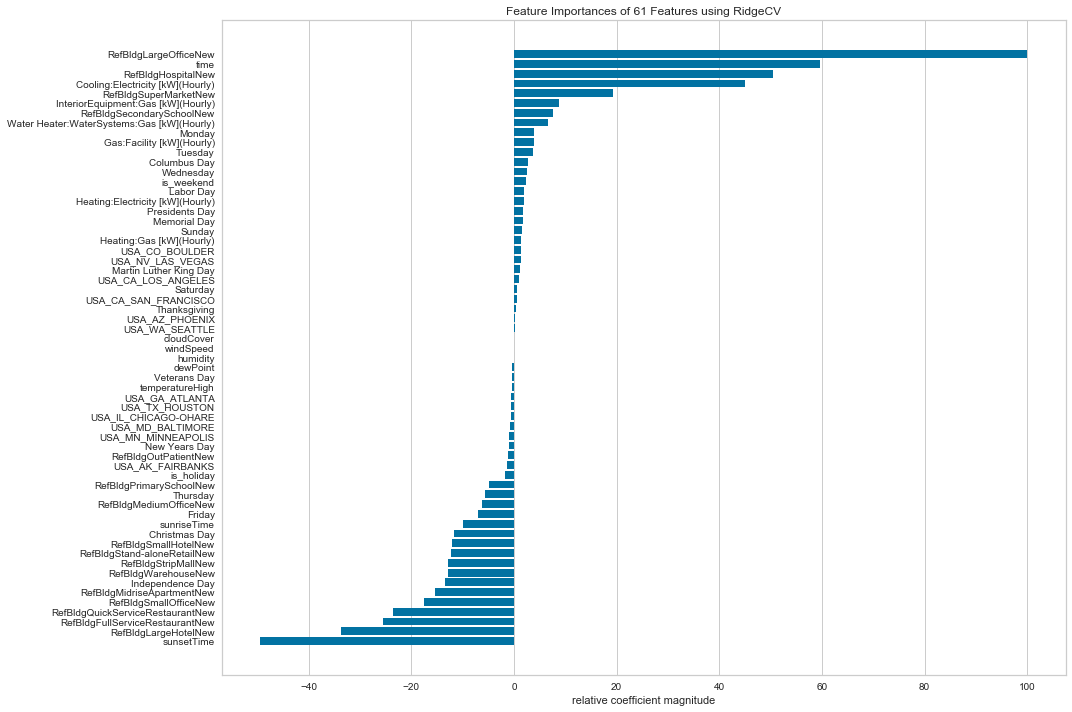

In [89]:
from yellowbrick.features import FeatureImportances

# model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(regr_cv, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

In [46]:
sfm = SelectFromModel(lasso)
sfm.fit(dataset_features, dataset_labels)
print(list(dataset_features.iloc[:, sfm.get_support(indices=True)]))

['Gas:Facility [kW](Hourly)', 'Heating:Electricity [kW](Hourly)', 'InteriorEquipment:Gas [kW](Hourly)', 'Water Heater:WaterSystems:Gas [kW](Hourly)', 'temperatureHigh', 'dewPoint', 'Friday', 'Thursday', 'RefBldgFullServiceRestaurantNew', 'RefBldgHospitalNew', 'RefBldgLargeOfficeNew', 'RefBldgOutPatientNew', 'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew', 'RefBldgSuperMarketNew']


In [47]:
lasso.fit(dataset_features, dataset_labels)
print(list(zip(dataset_features, lasso.coef_.tolist())))

[('Gas:Facility [kW](Hourly)', 0.045840402340256235), ('Heating:Electricity [kW](Hourly)', 0.03237911157377741), ('Heating:Gas [kW](Hourly)', 0.0), ('InteriorEquipment:Gas [kW](Hourly)', 0.1612329714062972), ('Water Heater:WaterSystems:Gas [kW](Hourly)', 0.07968287517371708), ('temperatureHigh', 0.07197833266848991), ('dewPoint', 0.010230689382615734), ('humidity', 0.0), ('windSpeed', -0.0), ('cloudCover', -0.0), ('Christmas Day', -0.0), ('Columbus Day', 0.0), ('Independence Day', -0.0), ('Labor Day', 0.0), ('Martin Luther King Day', 0.0), ('Memorial Day', 0.0), ('New Years Day', -0.0), ('Presidents Day', 0.0), ('Thanksgiving', -0.0), ('Veterans Day', -0.0), ('is_weekend', 0.0), ('is_holiday', -0.0), ('Friday', -0.089327465614483), ('Monday', 0.0), ('Saturday', 0.0), ('Sunday', 0.0), ('Thursday', -0.06215063848637268), ('Tuesday', 0.0), ('Wednesday', 0.0), ('RefBldgFullServiceRestaurantNew', -0.15029007863091937), ('RefBldgHospitalNew', 2.408857066341961), ('RefBldgLargeHotelNew', -0.0

In [93]:
# X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.01)
tscv = TimeSeriesSplit(n_splits=10)
#kf = KFold(n_splits=2, random_state=None, shuffle=False)
rmse = []
r2 = []
indices = []
for train_index, test_index in tscv.split(scaled_df):
    X_train, X_test = dataset_features.iloc[train_index], dataset_features.iloc[test_index]
    indices.append(train_index)
    y_train, y_test = dataset_labels.iloc[train_index], dataset_labels.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    expected = y_test
    predicted = model.predict(X_test)
    rmse.append(mse(expected, predicted))
    r2.append(r2_score(expected, predicted))
    
print('Linear Regression model')
print('Mean Squared Error: {}'.format(rmse))
print('Coefficient of Determination: {}'.format(r2))

Linear Regression model
Mean Squared Error: [176062377252752.44, 0.08474964571023226, 0.08216249587377951, 2335018555871000.0, 1.356870459719745e+19, 0.08991122654382096, 551102586749.6068, 2.952591547781843e+18, 534033202088489.2, 2261221636577813.5]
Coefficient of Determination: [-211988730522941.6, 0.9077673523989793, 0.9241176857248917, -2078885830432756.8, -1.1951715681168026e+19, 0.9217524595038287, -479222688051.5762, -2.845607632340088e+18, -577170056657143.4, -2746083719260653.5]
